### Train DNN

In [15]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
#from sklearn.model_selection import StratifiedKFold, KFold
#from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, TensorDataset, DataLoader
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


import torch.nn.functional as F
import sys
module_path = Path().resolve().parents[1] / "src" / "models"

# Append the directory to sys.path
sys.path.append(str(module_path))


from trainDNN import *
from explainDNN import *
from predictDNN import *

module_path = Path().resolve().parents[1] / "src" / "postprocessing"

# Append the directory to sys.path
sys.path.append(str(module_path))


from getModelPerformance import *

#### Load features

In [16]:
feature_path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_DO_men_v2"
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labels.npy"))
lats = np.load(Path(feature_path / "numpy_lat.npy"))
lons = np.load(Path(feature_path / "numpy_lon.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)


In [17]:
features.shape[1]

139

In [18]:
features.shape

(15725, 139)

#### Define the neural network architecture

In [19]:
loss_fn = torch.nn.MSELoss()


In [20]:
class DNN(torch.nn.Module):
    def __init__(self, layer_width):
        super(DNN, self).__init__()

        self.do_prob = 0.2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(features.shape[1], layer_width[0]),
            torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], layer_width[1]),
            torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[2]),
            torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[3]),
            torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[4]),
            torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[5]),
            torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[6]),
            torch.nn.BatchNorm1d(layer_width[6]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
        )

        self.decoder = torch.nn.Sequential(

            torch.nn.Linear(layer_width[6], layer_width[5]),
            #torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[4]),
            #torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[3]),
            #torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[2]),
            #torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[1]),
            #torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[0]),
            #torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], features.shape[1])
        )

        self.supervised = torch.nn.Sequential(
            torch.nn.Linear(layer_width[6], layer_width[7]),
            torch.nn.BatchNorm1d(layer_width[7]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[7], layer_width[8]),
            torch.nn.BatchNorm1d(layer_width[8]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[8], layer_width[9]),
            torch.nn.BatchNorm1d(layer_width[9]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[9], 1)

        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        targets = self.supervised(encoded)
        #return decoded, targets
        return targets
        
def initialize_weights(m):

    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)


In [21]:

input_dim = features.shape[1]  # Replace with the actual input dimension
layer_widths = [128, 128, 128, 128, 128, 128, 128, 128, 128, 128]  # Define your desired layer widthsmodel = DNN(layer_widths)#DNN(input_dim, layer_widths)model = DNN(layer_widths)#DNN(input_dim, layer_widths)



In [22]:
# Model Initialization
model = DNN(layer_widths)
model = model.double()
model.apply(initialize_weights)


if torch.cuda.is_available():
    model = model.cuda()
    loss_fn = loss_fn.cuda()



In [23]:
features.shape

(15725, 139)

In [24]:
features, labels, lats, lons = preprocess_features_labels(features, labels, lats, lons, X_mean, X_std) 
np.save("preprocessed/features_DO", features)
np.save("preprocessed/labels_DO", labels)
np.save("preprocessed/lats_DO", lats)
np.save("preprocessed/lons_DO", lons)

Duplicate row with index [5125 5126 5127 5128 5129 5130 5131 5132 5133 5134] was in group 97 and was replaced with NaN values
Duplicate row with index [2430 4774 4775 4776 4777 4778 4779 4780 4781 4782 4783 4784 4785 4786
 4787 4788 4789 4790 4791 4792 4793 5432 5433 5434 5435 5436 5437 5438
 5439 5440 5441 5442 5443 5444 5445 5446 5447 5448 5449 5450 5451 5452
 5453 5454 5455] was in group 114 and was replaced with NaN values
Duplicate row with index [5664 5665 6761 6762] was in group 127 and was replaced with NaN values
Duplicate row with index [6143 7386] was in group 140 and was replaced with NaN values
Duplicate row with index [2434 5467 5468 5469 5470 5471 5472 5473 5474 5475 5476 5477 5478] was in group 144 and was replaced with NaN values
Duplicate row with index [ 5841  5842 11734 11735] was in group 146 and was replaced with NaN values
Duplicate row with index [2438 2439 4823 4824 4825 4826 4827 4828 4829 4830 4831 4832 4833 4834
 4835 5479 5480 5481 5482 5483 5484 5485 5486 

In [20]:
features = np.load("preprocessed/features_DO.npy")
labels = np.load("preprocessed/labels_DO.npy")

In [21]:
features = torch.tensor(features)
labels = torch.tensor(labels)

In [22]:

trainloader, testloader = create_train_test_loader(features, labels, batch_size = 200, test_size_ratio=1/7, shuffle=True)

Train data size
6526
Test data size
343


In [23]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: DNN(
  (encoder): Sequential(
    (0): Linear(in_features=139, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affi

In [ ]:
# GPU intensive operation!!
num_epochs = 1000
training_accuracy, training_losses, training_mae, learning_rate, evaluation_losses, evaluation_mae, true_labels, pred_labels =  train_model(model, loss_fn, trainloader, testloader, num_epochs = num_epochs)

epoch: 0 | Training Loss: 1.536 | MAE: 0.785 | LR: 0.0100000 |
epoch: 0 | Testing Loss: 6.115 | MAE: 0.884  |

epoch: 1 | Training Loss: 0.852 | MAE: 0.553 | LR: 0.0100000 |
epoch: 1 | Testing Loss: 0.957 | MAE: 0.531  |

epoch: 2 | Training Loss: 0.788 | MAE: 0.505 | LR: 0.0100000 |
epoch: 2 | Testing Loss: 0.903 | MAE: 0.452  |

epoch: 3 | Training Loss: 0.705 | MAE: 0.484 | LR: 0.0080000 |
epoch: 3 | Testing Loss: 0.962 | MAE: 0.406  |

epoch: 4 | Training Loss: 0.650 | MAE: 0.464 | LR: 0.0080000 |
epoch: 4 | Testing Loss: 0.795 | MAE: 0.416  |

epoch: 5 | Training Loss: 0.633 | MAE: 0.445 | LR: 0.0064000 |
epoch: 5 | Testing Loss: 0.645 | MAE: 0.394  |

epoch: 6 | Training Loss: 0.632 | MAE: 0.446 | LR: 0.0051200 |
epoch: 6 | Testing Loss: 0.677 | MAE: 0.402  |

epoch: 7 | Training Loss: 0.578 | MAE: 0.436 | LR: 0.0051200 |
epoch: 7 | Testing Loss: 0.748 | MAE: 0.413  |

epoch: 8 | Training Loss: 0.602 | MAE: 0.429 | LR: 0.0051200 |
epoch: 8 | Testing Loss: 0.693 | MAE: 0.377  |

e

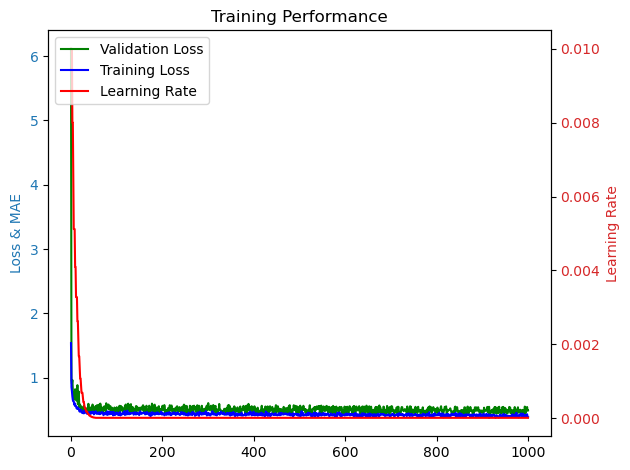

In [30]:
#num_epochs = 1000
plot_model_performance(num_epochs, evaluation_losses[-1000:], training_losses[-1000:], learning_rate[-1000:])

In [31]:
len(evaluation_losses[-1000:])

1000

In [32]:
output_path = Path().resolve().parents[2] / "nn4sedratetoc" / "data" / "output" / "scatterplots_TOC" / "scatter_plot_TOC_noconstraint_supervised_DO_men_test.png"
output_path = str(output_path)
test_labels, test_targets = evaluate_model(model, testloader, output_path)

(343,)
(343,)
correlation coefficient:
0.8892116878234946
mae:
0.32401961092735143
mse:
0.4857634688456631
rmse:
0.6969673370005679


In [33]:
all_labels, all_targets =  evaluate_all_predictions(model, features, labels, output_path)

correlation coefficient:
0.8802627444637336
mae:
0.3075903841088176
mse:
0.30999589886658535
rmse:
0.5567727533442933


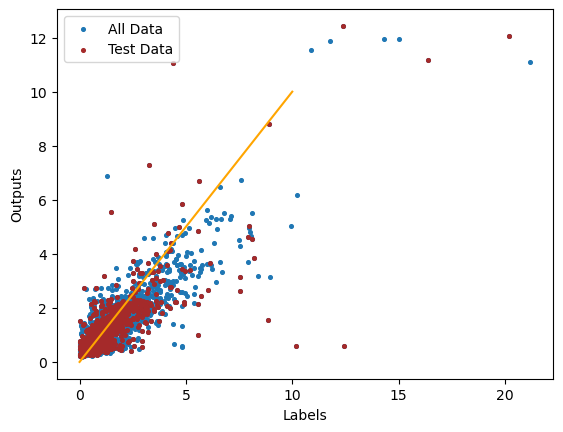

In [100]:
# Scatter plot with different colors for test labels and test targets
plt.scatter(all_labels, all_targets, label='All Data', s= 7)
plt.scatter(test_labels, test_targets, label='Test Data', color='brown', s=7)  # Add this line

line = np.linspace(0, 10, 100)

# Plot the reference line
plt.plot(line, line, 'orange')

# Set labels and title
plt.xlabel("Labels")
plt.ylabel("Outputs")

# Add legend
plt.legend()

In [101]:
#"""
np.save("all_labels_NN_DO_v3", all_labels)
np.save("all_predictions_NN_DO_v3", all_targets)
np.save("test_labels_NN_DO_v3", test_labels)
np.save("test_predictions_NN_DO_v3", test_targets)
#"""

### Explain DNN using SHAP values (Find feature importance)

In [21]:
import shap
import pandas as pd

# Convert the input features to a PyTorch tensor with the correct data type
features = torch.tensor(features, dtype=torch.float64)

if torch.cuda.is_available():
    features = features.cuda()

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [22]:
# GPU intensive operation!!!
explain_shap(model, features, feature_names=None, explainer_path='preprocessed/explainer_DO_v2.pkl', shap_values_path='preprocessed/shap_values_DO_v2.pkl', force_plot_index=0, summary_max_display=10)

In [12]:
# Load the explainer and SHAP values
with open('preprocessed/explainer_DO_v2.pkl', 'rb') as explainer_file:
    explainer = pickle.load(explainer_file)

with open('preprocessed/shap_values_DO_v2.pkl', 'rb') as shap_values_file:
    shap_values = pickle.load(shap_values_file)

In [16]:
shap_values.shape

(6869, 139)

In [22]:
features.shape

(6869, 139)

In [28]:
force_plot_index=0
summary_max_display=10
feature_names = None
# Print or return the SHAP values for the specified instance
if feature_names is None:
    feature_names = [f'Feature {i}' for i in range(features.shape[1])]

# Example: Display SHAP values for a specific instance (index=force_plot_index)
if force_plot_index < len(features):
    shap_values_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Value': shap_values[0][force_plot_index]
    })
    print(shap_values_df)

         Feature  SHAP Value
0      Feature 0   -0.007958
1      Feature 1   -0.007958
2      Feature 2   -0.007958
3      Feature 3   -0.007958
4      Feature 4   -0.007958
..           ...         ...
134  Feature 134   -0.007958
135  Feature 135   -0.007958
136  Feature 136   -0.007958
137  Feature 137   -0.007958
138  Feature 138   -0.007958

[139 rows x 2 columns]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


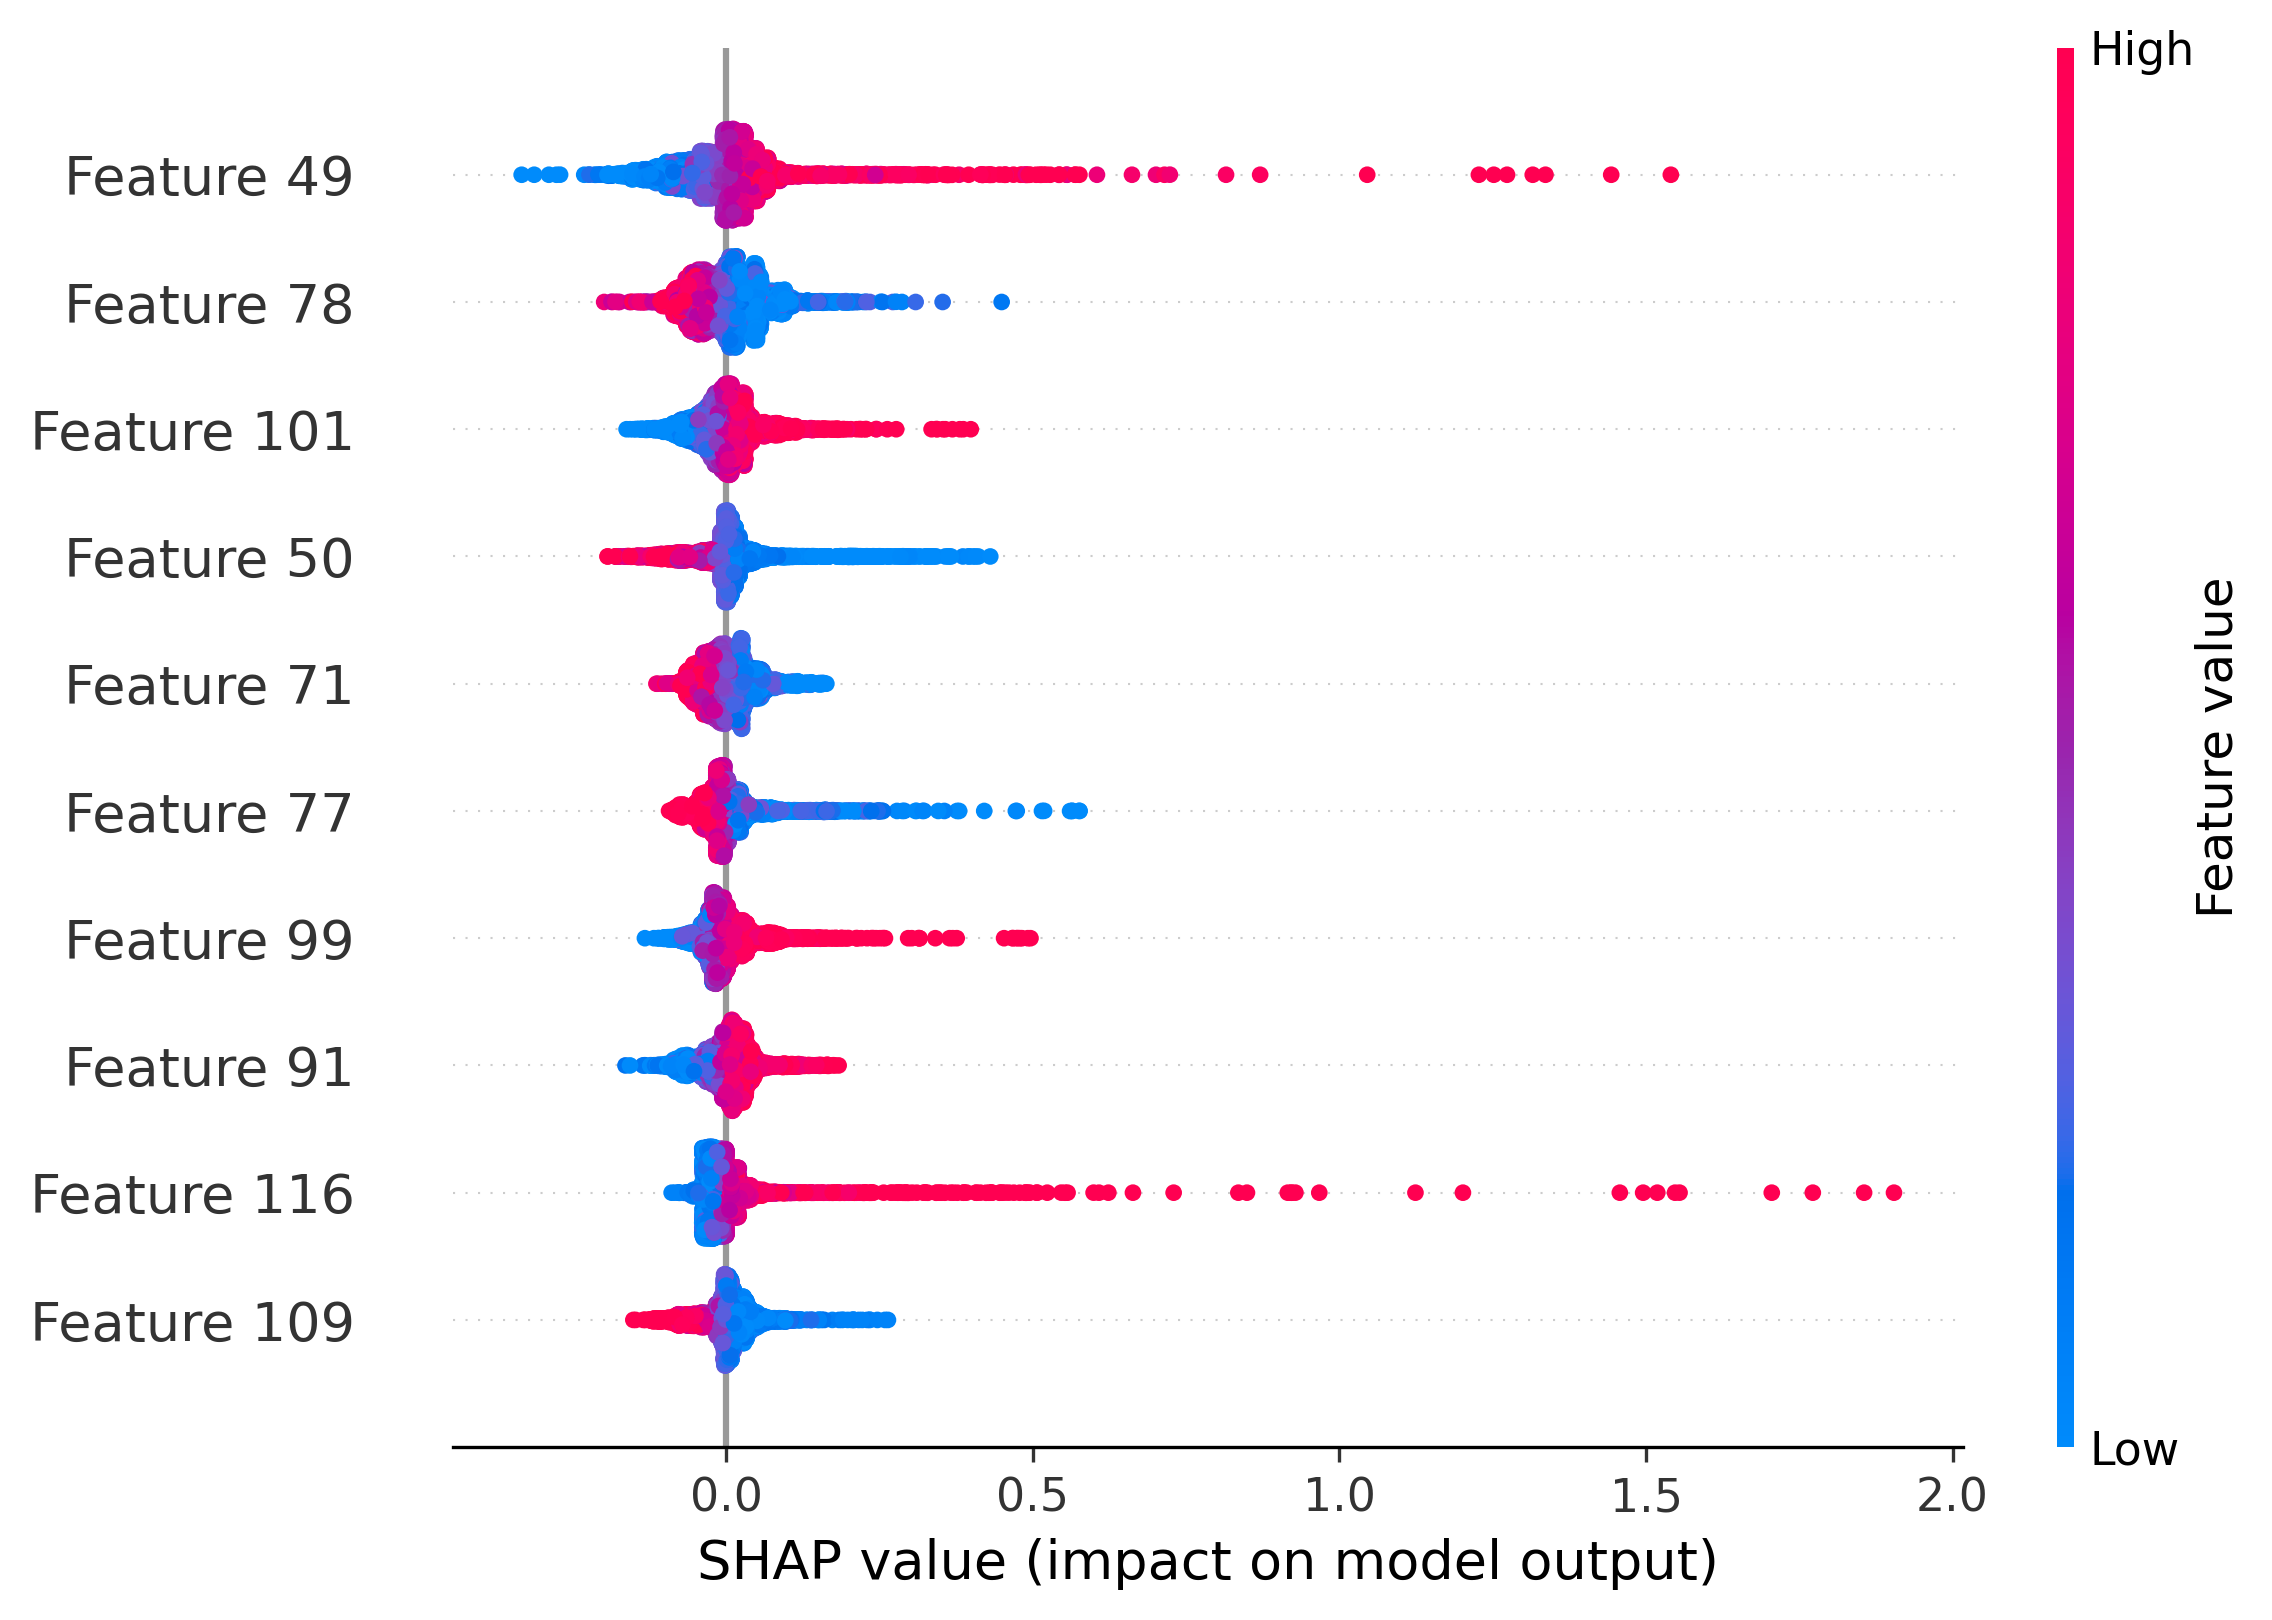

In [41]:
plt.figure(dpi=300)
shap.summary_plot(shap_values, features, max_display=10)

In [36]:
# Convert features and SHAP values to NumPy arrays
features_np = features#.cpu().detach().numpy()
shap_values_np = shap_values#[0]#.cpu().detach().numpy()
# Create a DataFrame for SHAP values
if feature_names is None:
    feature_names = [f'Feature {i}' for i in range(features_np.shape[1])]

shap_values_df = pd.DataFrame(shap_values_np, columns=feature_names)

# Calculate mean absolute SHAP value for each feature
feature_importance = shap_values_df.abs().mean().sort_values(ascending=False)

# Sort the SHAP values DataFrame by feature importance
shap_values_df_sorted = shap_values_df[feature_importance.index]


In [40]:
feature_importance.to_csv("feature_importance_DO")

In [27]:
torch.save(model.state_dict(), path = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_DO.pth")

### Predict using the trained DNN

In [1]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
#from sklearn.model_selection import StratifiedKFold, KFold
#from sklearn.model_selection import train_test_split
import os
import gc






from os import walk  
feature_path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_DO_men_v2"
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)

#dataset_path = Path(Path().resolve().parents[2] / "Data" / "LeeKNNsTOC" / "WorldFeaturesAll")#ChlorWorldFeatures
dataset_path = Path().resolve().parents[1] / "data" / "interim" / "worldfeatures" / "WorldFeaturesAllnoNaN_SedTOC"
files = []

for (dirpath, dirnames, filenames) in walk(dataset_path):
    files.extend(filenames)
    break

files.sort()


features = np.load(Path(dataset_path / files[0]))
prediction_sum_save = Path().resolve().parents[1] / "data" / "interim" / "predictions" / "predictions_DO_v2"

In [21]:

model.eval()
enable_dropout(model) #for mc dropout


chunk_shape = [6,4320] #360 chunks

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0' if torch.cuda.is_available() else 
#print(physical_devices)
model.to(device)
print(device)
model.double()



cuda:0


DNN(
  (encoder): Sequential(
    (0): Linear(in_features=139, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [22]:
features = np.load(Path(dataset_path / files[0]))

chunk_shape = [6,4320] #360 chunks


first_run = True
ii = 0

for count, file in enumerate(files):
    #if count > 2:
    #    break
    features = np.load(Path(dataset_path / file))
    features = np.divide((features - X_mean), X_std)

    features = torch.tensor(features)
    features = features.to(device)

    # Perform multiple forward passes with dropout
    num_samples = 100  # number of monte carlo forward passes: gives us the number of predictions or the size of the prediction ensemble
    predictions_sum = np.zeros((num_samples, chunk_shape[0], chunk_shape[1]))

    with torch.no_grad():
        for i in range(num_samples):
            predictions = model(features)
         
            # Store predictions for later averaging
            predictions_sum[i] = predictions.cpu().detach().numpy().reshape(chunk_shape)

    # Average predictions over all samples
    predictions_avg = np.mean(predictions_sum, axis=0)
    predictions_var = np.var(predictions_sum, axis=0)
    save_path = os.path.join(prediction_sum_save , f'predictions_sum_{ii}.npy')
    np.save(save_path, predictions_sum)
    #fit_params, failed_fits, failed_fit_details = fit_gaussian_to_predictions(predictions_sum)
    #print(failed_fits)

    if first_run:
        prediction_map2 = predictions_avg
        prediction_map2_var = predictions_var
        first_run = False
    else:
        prediction_map2 = np.append(prediction_map2, predictions_avg, axis=0)
        prediction_map2_var = np.append(prediction_map2_var, predictions_var, axis=0)

    ii += 1
    print("Prediction " + str(ii) + " done!")

    del features
    gc.collect()
    


In [2]:
#"""
import os
import numpy as np

# Get a list of files in the directory and sort them
files_in_dir = sorted([f for f in os.listdir(prediction_sum_save) if f.endswith('.npy')], key=lambda x: int(x.split('_')[-1][:-4]))


failed_fits_all = []
i = 0
first_run = True

# Load and concatenate each predictions_sum array along the second axis
for file in files_in_dir:
    file_path = os.path.join(prediction_sum_save, file)
    predictions_sum = np.load(file_path)
    
    if first_run:
        prediction_map_dist = predictions_sum
        first_run = False
    else:
        # Concatenate along the second axis (axis=1)
        prediction_map_dist = np.concatenate((prediction_map_dist, predictions_sum), axis=1)

    i += 1
    print(i)
np.save(Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_dist_DO_v2.npy", prediction_map_dist)
#"""

In [24]:
land_file = Path().resolve().parents[1] / "data" / "raw" / "island_map.npy"
land_map = np.load(land_file)
land_map[np.isnan(land_map)] = 1

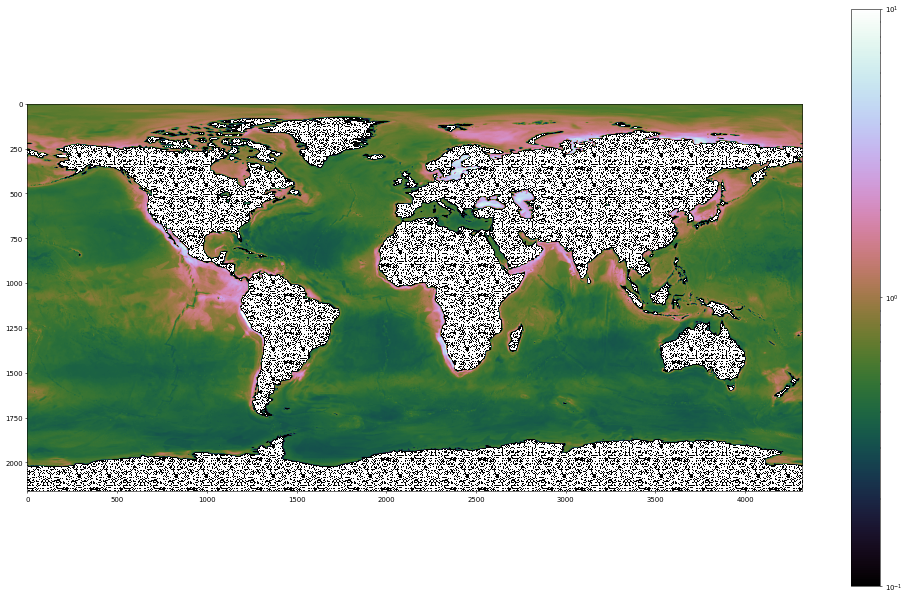

In [25]:
import matplotlib.colors as mcolors
prediction_map2 = np.rot90(np.rot90(np.fliplr(prediction_map2)))
plt.figure(figsize=[25, 15], dpi=50)
prediction_map2[land_map] = 0
plt.imshow(prediction_map2, norm=mcolors.LogNorm(vmin=1e-1, vmax=10),cmap="cubehelix")
cbar = plt.colorbar()

In [ ]:

np.save( Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_TOC_noconstraint_DO_v2.npy", prediction_map2)
#np.save( Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "uncertainty_map_TOC_noconstraint_supervised_men_DO.npy", prediction_map2_var)